In [1]:
# Execute this when running on Google Colab
!git clone https://github.com/matteomancini/SaltAndPepper.git
%cd SaltAndPepper

fatal: destination path 'SaltAndPepper' already exists and is not an empty directory.
/Users/bsms9gep/Code/SaltAndPepper/SaltAndPepper


In [2]:
from data import series_data
from importlib import import_module
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from util import train, plot_confusion_matrix, plot_loss_accuracy, plot_dataloader_distribution

/Users/bsms9gep/Code/SaltAndPepper/venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_name = 'cinc2017'
model_name = 'FullyConnectedNetwork'
train_ae = False
rearrange_tensor = False
units = 150
layers = 1
batch = 150
epochs = 10
device = 'cpu'

In [4]:
dataset = import_module('datasets.' + dataset_name)
model = getattr(import_module('model'), model_name)
ts, labels = dataset.load_data()
if rearrange_tensor:
    ts = ts.transpose(1, 2)
n_labels = int(labels.max()) + 1
label_names = dataset.get_label_names()

ts = (ts - ts.min())/(ts.max() - ts.min())

data = series_data.Series(ts, labels)
train_size = int(0.8 * len(data))
valid_size = len(data) - train_size
train_data, valid_data = random_split(data, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
validation_loader = DataLoader(valid_data, batch_size=batch, shuffle=False)
net = model(num_classes=n_labels, input_len=ts.size(2),
            hidden_units=units, hidden_layers=layers).to(device)
print(f'The number of samples for training is {train_size}.')
class_samples = [int(sum(labels==l))/len(labels) for l in range(n_labels)]
print(f'Samples per classes: {class_samples}')
class_samples_train = [sum([int(t[1])==l for t in list(train_data)])/len(list(train_data)) for l in range(n_labels)]
print(f'Samples per classes (training): {class_samples_train}')
class_samples_valid = [sum([int(v[1])==l for v in list(valid_data)])/len(list(valid_data)) for l in range(n_labels)]
print(f'Samples per classes (validation): {class_samples_valid}')
print(f'The number of parameters is {sum(p.numel() for p in net.parameters())}.')

Dataset already assembled in /Users/bsms9gep/Code/SaltAndPepper/datasets/cinc2017.
Dataset already assembled in /Users/bsms9gep/Code/SaltAndPepper/datasets/cinc2017.
The number of samples for training is 4630.
Samples per classes: [0.8724948168624741, 0.12750518313752593]
Samples per classes (training): [0.8721382289416847, 0.12786177105831534]
Samples per classes (validation): [0.8739205526770294, 0.12607944732297063]
The number of parameters is 1350452.


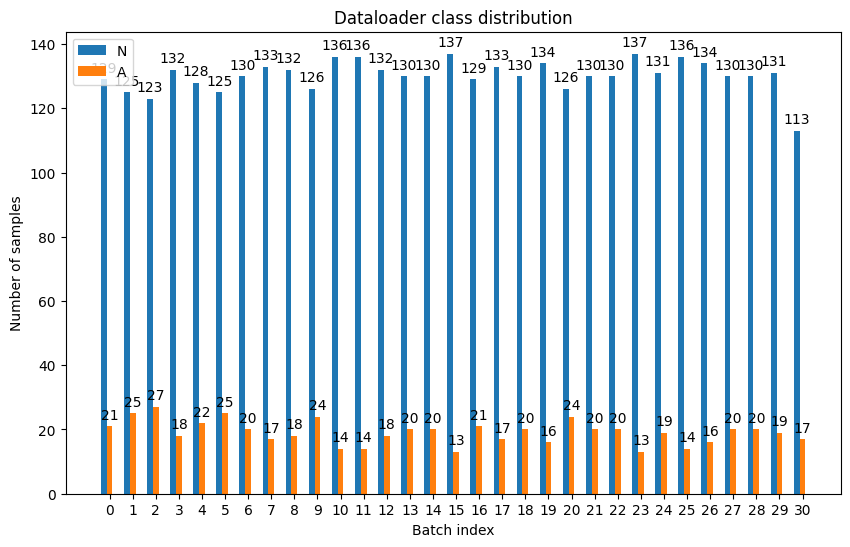

In [5]:
plot_dataloader_distribution(train_loader, label_names)

In [6]:
class_weights = [1/sum([int(t[1])==l for t in list(train_data)]) for l in range(n_labels)]
sample_weights = [class_weights[int(t[1])] for t in list(train_data)]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_data), replacement=True)
rebalanced_loader = DataLoader(train_data, sampler=sampler, batch_size=batch)

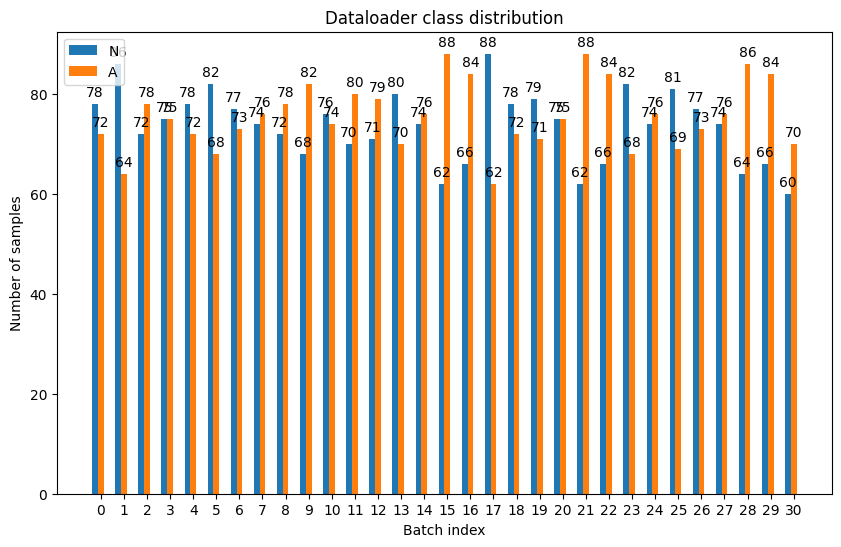

In [7]:
plot_dataloader_distribution(rebalanced_loader, label_names)

In [8]:
import torch.nn as nn

train_loss, train_acc, validation_loss, validation_acc, predictions, targets = train(
    net, device, train_loader, validation_loader, epochs, lr=0.001)

Training: 100%|███████████████████████████████████████| 10/10 [00:06<00:00,  1.54epoch/s, loss=0.529]


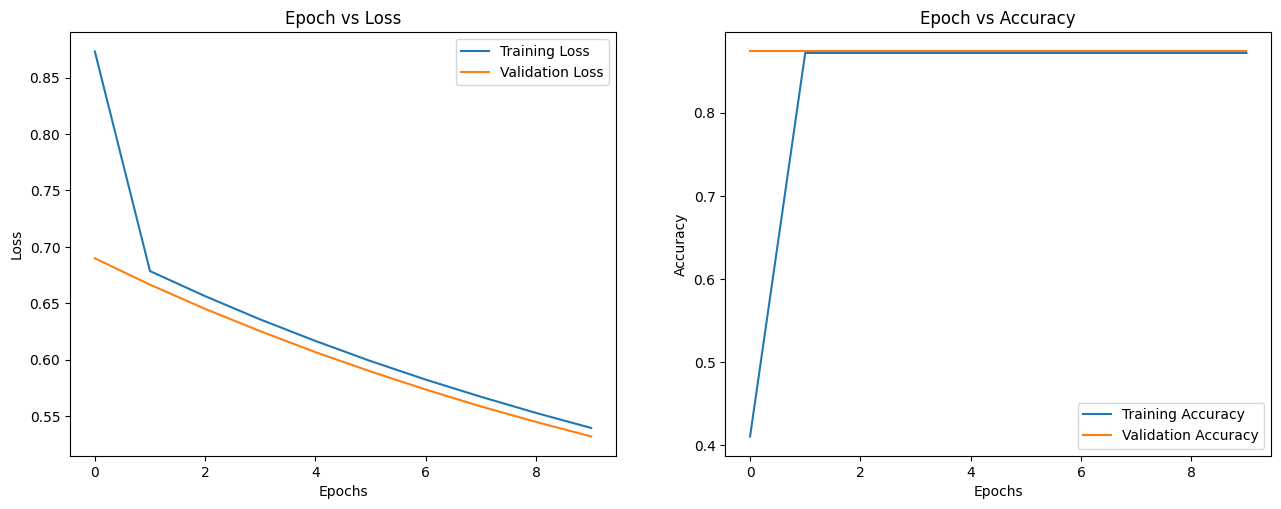

In [9]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

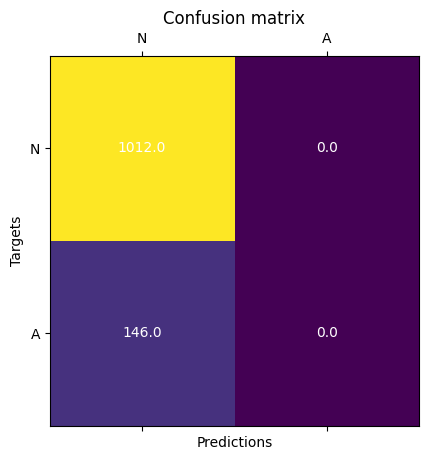

In [10]:
plot_confusion_matrix(targets, predictions, label_names)